In [1]:
import pyaudio, struct
import multiprocessing
import threading
import numpy as np
import _thread
import time
from scipy import signal
import cv2
import math
from math import sin, cos, pi
import imutils
import os
import wave
from os.path import realpath, normpath

import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster

from matplotlib import pyplot as plt

<b>Global Variable Shared by Image Process and Audio Generation</b>

In [2]:
KS = [0] * 12
CONTINUE = True

<b>Utility Function</b>

In [3]:
def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

<b>Face Recognition With Haar Feature-Based Cascade Classifiers</b>

In [4]:
def getDetectedFace(frame):
    """
    frame    : the input frame in BGR color space
    """
    NUM_CLUSTERS = 5
    FaceDetected = False
    peakHSV = None
    # get xml path 
    s = realpath(cv2.__file__).split("\\")[:-1]
    xmlPath = os.path.join(os.path.join(*s), "data")
    # Load the cascade classifier
    face_cascade = cv2.CascadeClassifier(os.path.join(xmlPath, 'haarcascade_frontalface_default.xml'))
    eye_cascade = cv2.CascadeClassifier(os.path.join(xmlPath, 'haarcascade_eye.xml'))
    # Convert the frame from default BGR to Gray color space
    frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Use Histogram Equalization to enhance the contrast
    frameGray = cv2.equalizeHist(frameGray)

    # detect face in current frame
    faces = face_cascade.detectMultiScale(frameGray, 1.3, 5)
    for (x,y,w,h) in faces:
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = frameGray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    if len(faces) > 0:
        print("face detected")
        FaceDetected = True
        image = frame[y:y+h, x:x+w]
        shape = image.shape
        ar = image.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
        codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
        vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
        counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
        index_max = scipy.argmax(counts)                    # find most frequent
        peak = codes[index_max]
        peak = peak.reshape(1,1,3)
        peak = peak.astype("uint8")
        peakHSV = cv2.cvtColor(peak, cv2.COLOR_BGR2HSV)

    return FaceDetected, frame, peakHSV

<b>Skin Detection using HSV boundary</b>

In [5]:
def getSkinMask(frame, lower, upper):
    """
    frame    : the input frame in BGR color space
    lower    : the lower bound for skin in HSV space
    upper    : the upper bound for skin in HSV space
    """
    # convert the frame from default BGR to HSV color space
    frameHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # apply the skin boundary to frame in HSV, get the mask for detected skin area in current frame
    skinMask = cv2.inRange(frameHSV, lower, upper)
    # apply morphological operation to the mask to remove noise
    # define the kernel for morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # (1) use morphological opening to remove small object
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    # (2) use morphological closing to fill small holes in object
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    
    return skinMask

<b>Run Program</b>

Run Camera

In [6]:
def VideoProcess():
    global KS, CONTINUE
    # get the default camera in your system configuration
    cap = cv2.VideoCapture(0)

    peakHSVs = []
    BoundaryDefined = False

    ifPressed = [0] * 12

    while(True):
        # get current frame
        ret, frame = cap.read()
        # flip the frame horizontally
        frame = cv2.flip(frame, 1)
        # check if frame is successfully read
        if not ret:
            break
        # show the current frame
        cv2.imshow('frame',  frame)

        # resize the frame to decrease the computation
        # frame = imutils.resize(frame, width = 500)

        if len(peakHSVs) < 10:
            # get face roi
            ret, faceDetected, peakHSV = getDetectedFace(frame)
            # display face roi
            cv2.imshow('faceDetected',  faceDetected)
            # put detected face to list
            if ret:
                peakHSVs.append(peakHSV)

        elif not BoundaryDefined:
            meanHSV = np.mean(peakHSVs, axis=0)
            meanHSV = meanHSV.astype("uint8")
            print(meanHSV)
            lower = meanHSV - [10, 50, 50]
            upper = meanHSV + [10, 50, 50]
            BoundaryDefined = True
            print("boundary defined")
            meanRGB = cv2.cvtColor(meanHSV, cv2.COLOR_HSV2RGB)
            blank_image = np.zeros((100,100,3), np.uint8)
            blank_image[:,:] = meanRGB
            plt.imshow(blank_image)
            plt.show()


        if BoundaryDefined:
            # get skin mask
            skinMask = getSkinMask(frame, lower, upper)
            skinMask[np.where(skinMask==255)] = 1
            # apply mask to frame
            frame = apply_mask(frame, skinMask, color=[1.0, 0, 0], alpha=0.5)
            # display skin mask
            cv2.imshow('skinMask',  skinMask)
            # plot key board on current frame 
            w,h,c = frame.shape
            for i in range(12):
                # get key position
                y1 = int(w / 3) * 2
                x1 = int(h / 12) * i 
                kw = int(h / 30)
                kh = int(w / 3)
                # plot key on current frame
                cv2.rectangle(frame,(x1, y1),(x1 + kw , y1 + kh),(0,255,0),2)
                # check if pressed:
                p = np.sum(skinMask[y1:y1+kh,x1:x1 + kw]) * 1.0 / (kh * kw)
                if p > 0.5:
                    if ifPressed[i] == 0:
                        print("key {} triggered".format(i+1))
                        KS[i] = 1
                        """
                        Generate Sound Here For corresponding key (key i + 1)
                        """
                    ifPressed[i] = 1
                else:
                    ifPressed[i] = 0

            cv2.imshow('Resultframe',  frame)

        # exit the program when "q" key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            CONTINUE = False
            break

    # release the camera and destroy the window when program is terminated
    cap.release()
    cv2.destroyAllWindows()

<b>Audio Generation</b>

In [7]:
def AudioGeneration():
    global KS, CONTINUE
    
    BLOCKLEN   = 64        # Number of frames per block
    WIDTH       = 2         # Bytes per sample
    CHANNELS    = 1         # Mono
    RATE        = 16000    # Frames per second

    MAXVALUE = 2**15-1  # Maximum allowed output signal value (because WIDTH = 2)

    # Parameters
    Ta = 1      # Decay time (seconds)
    f0 = 440    # Frequency (Hz)
    f = np.zeros(12)
    for n in range(12):
        f[n] = f0 * (2 ** (n/12))

    # Pole radius and angle
    r = 0.01**(1.0/(Ta*RATE))       # 0.01 for 1 percent amplitude
    om = np.zeros(12)
    for n in range(12):
        om[n] = 2.0 * pi * float(f[n])/RATE
        
    
    # Filter coefficients (second-order IIR)
    a1 = [1, -2*r*cos(om[0]), r**2]
    b1 = [r*sin(om[0])]
    a2 = [1, -2*r*cos(om[1]), r**2]
    b2 = [r*sin(om[1])]
    a3 = [1, -2*r*cos(om[2]), r**2]
    b3 = [r*sin(om[2])]
    a4 = [1, -2*r*cos(om[3]), r**2]
    b4 = [r*sin(om[3])]
    a5 = [1, -2*r*cos(om[4]), r**2]
    b5 = [r*sin(om[4])]
    a6 = [1, -2*r*cos(om[5]), r**2]
    b6 = [r*sin(om[5])]
    a7 = [1, -2*r*cos(om[6]), r**2]
    b7 = [r*sin(om[6])]
    a8 = [1, -2*r*cos(om[7]), r**2]
    b8 = [r*sin(om[7])]
    a9 = [1, -2*r*cos(om[8]), r**2]
    b9 = [r*sin(om[8])]
    a0 = [1, -2*r*cos(om[9]), r**2]
    b0 = [r*sin(om[9])]
    a_ = [1, -2*r*cos(om[10]), r**2]
    b_ = [r*sin(om[10])]
    aEQ = [1, -2*r*cos(om[11]), r**2]
    bEQ = [r*sin(om[11])]

    ORDER = 2   # filter order
    states1 = np.zeros(ORDER)
    states2 = np.zeros(ORDER)
    states3 = np.zeros(ORDER)
    states4 = np.zeros(ORDER)
    states5 = np.zeros(ORDER)
    states6 = np.zeros(ORDER)
    states7 = np.zeros(ORDER)
    states8 = np.zeros(ORDER)
    states9 = np.zeros(ORDER)
    states0 = np.zeros(ORDER)
    states_ = np.zeros(ORDER)
    statesEQ = np.zeros(ORDER)
    x1 = np.zeros(BLOCKLEN)     #La
    x2 = np.zeros(BLOCKLEN)     #La#
    x3 = np.zeros(BLOCKLEN)     #Si
    x4 = np.zeros(BLOCKLEN)     #Do
    x5 = np.zeros(BLOCKLEN)     #Do#
    x6 = np.zeros(BLOCKLEN)     #Re
    x7 = np.zeros(BLOCKLEN)     #Re#
    x8 = np.zeros(BLOCKLEN)     #Mi
    x9 = np.zeros(BLOCKLEN)     #Fa
    x0 = np.zeros(BLOCKLEN)     #Fa#
    x_ = np.zeros(BLOCKLEN)     #So
    xEQ = np.zeros(BLOCKLEN)    #So#

    # Open the audio output stream
    p = pyaudio.PyAudio()
    PA_FORMAT = pyaudio.paInt16
    stream = p.open(
            format      = PA_FORMAT,
            channels    = CHANNELS,
            rate        = RATE,
            input       = False,
            output      = True,
            frames_per_buffer = 128)
# specify low frames_per_buffer to reduce latency
    
    while CONTINUE:

        if KS[0] and CONTINUE:
            x1[0] = 10000.0
        if KS[1] and CONTINUE:
            x2[0] = 10000.0
        if KS[2] and CONTINUE:
            x3[0] = 10000.0
        if KS[3] and CONTINUE:
            x4[0] = 10000.0
        if KS[4] and CONTINUE:
            x5[0] = 10000.0
        if KS[5] and CONTINUE:
            x6[0] = 10000.0
        if KS[6] and CONTINUE:
            x7[0] = 10000.0
        if KS[7] and CONTINUE:
            x8[0] = 10000.0
        if KS[8] and CONTINUE:
            x9[0] = 10000.0
        if KS[9] and CONTINUE:
            x0[0] = 10000.0
        if KS[10] and CONTINUE:
            x_[0] = 10000.0
        if KS[11] and CONTINUE:
            xEQ[0] = 10000.0

        [y1, states1] = signal.lfilter(b1, a1, x1, zi = states1)
        [y2, states2] = signal.lfilter(b2, a2, x2, zi = states2)
        [y3, states3] = signal.lfilter(b3, a3, x3, zi = states3)
        [y4, states4] = signal.lfilter(b4, a4, x4, zi = states4)
        [y5, states5] = signal.lfilter(b5, a5, x5, zi = states5)
        [y6, states6] = signal.lfilter(b6, a6, x6, zi = states6)
        [y7, states7] = signal.lfilter(b7, a7, x7, zi = states7)
        [y8, states8] = signal.lfilter(b8, a8, x8, zi = states8)
        [y9, states9] = signal.lfilter(b9, a9, x9, zi = states9)
        [y0, states0] = signal.lfilter(b0, a0, x0, zi = states0)
        [y_, states_] = signal.lfilter(b_, a_, x_, zi = states_)
        [yEQ, statesEQ] = signal.lfilter(bEQ, aEQ, xEQ, zi = statesEQ)

        x1[0] = 0.0
        x2[0] = 0.0
        x3[0] = 0.0
        x4[0] = 0.0
        x5[0] = 0.0
        x6[0] = 0.0
        x7[0] = 0.0
        x8[0] = 0.0
        x9[0] = 0.0
        x0[0] = 0.0
        x_[0] = 0.0
        xEQ[0] = 0.0

        KS = [0] * 12

        Y = y1+y2+y3+y4+y5+y6+y7+y8+y9+y0+y_+yEQ
        Y = Y.astype(int)
        Y = np.clip(Y, -MAXVALUE, MAXVALUE)     # Clipping

        binary_data = struct.pack('h' * BLOCKLEN, *Y);    # Convert to binary binary data
        stream.write(binary_data, BLOCKLEN)               # Write binary binary data to audio output

    print('* Done.')

    # Close audio stream
    stream.stop_stream()
    stream.close()
    p.terminate()
    

<b>Run Real-Time Video Process and Real-Time Audio Generation on Two Threads</b>

<b>Currently, Multi-Threding May Raise Error On Mac, Tested on Windows</b>

face detected
face detected
face detected
face detected
face detected
face detected
face detected
face detected
face detected
face detected
[[[  7 120 107]]]
boundary defined


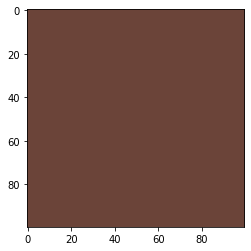

key 6 triggered
key 9 triggered
key 10 triggered
key 3 triggered
key 2 triggered
key 12 triggered
key 11 triggered
key 10 triggered
key 10 triggered
key 9 triggered
key 8 triggered
key 7 triggered
key 6 triggered
key 5 triggered
key 4 triggered
key 3 triggered
key 2 triggered
key 1 triggered
key 1 triggered
key 4 triggered
key 5 triggered
key 7 triggered
key 8 triggered
key 10 triggered
key 11 triggered
key 12 triggered
key 12 triggered
key 10 triggered
key 11 triggered
key 8 triggered
key 7 triggered
key 5 triggered
key 6 triggered
key 4 triggered
key 2 triggered
key 3 triggered
key 1 triggered
key 1 triggered
key 2 triggered
key 3 triggered
key 4 triggered
key 6 triggered
key 11 triggered
key 12 triggered
key 10 triggered
key 8 triggered
key 7 triggered
key 6 triggered
key 5 triggered
key 4 triggered
key 6 triggered
key 7 triggered
key 8 triggered
key 9 triggered
key 10 triggered
key 2 triggered
key 1 triggered
key 12 triggered
key 12 triggered
key 11 triggered
key 11 triggered
key 1

In [8]:
threads = []

t1 = threading.Thread(target=VideoProcess)
threads.append(t1)
t2 = threading.Thread(target=AudioGeneration)
threads.append(t2)
for t in threads:
    t.start()
for t in threads:
    t.join()